<a href="https://colab.research.google.com/github/seshadri-patra/Articulyze/blob/main/Time_and_Space_Complexity_Analyser(STEP_1%2C1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import time

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [ ]:
sample_code = """
def simple_loop(n):
    for i in range(n):
        print(f"Step {i}")
"""

# Parse the code into an AST
tree = ast.parse(sample_code)
print("🌳 Abstract Syntax Tree structure:")
print(ast.dump(tree, indent=2))

🌳 Abstract Syntax Tree structure:
Module(
  body=[
    FunctionDef(
      name='simple_loop',
      args=arguments(
        posonlyargs=[],
        args=[
          arg(arg='n')],
        kwonlyargs=[],
        kw_defaults=[],
        defaults=[]),
      body=[
        For(
          target=Name(id='i', ctx=Store()),
          iter=Call(
            func=Name(id='range', ctx=Load()),
            args=[
              Name(id='n', ctx=Load())],
            keywords=[]),
          body=[
            Expr(
              value=Call(
                func=Name(id='print', ctx=Load()),
                args=[
                  JoinedStr(
                    values=[
                      Constant(value='Step '),
                      FormattedValue(
                        value=Name(id='i', ctx=Load()),
                        conversion=-1)])],
                keywords=[]))],
          orelse=[])],
      decorator_list=[])],
  type_ignores=[])


In [ ]:
class LoopInstrumentor(ast.NodeTransformer):
    """
    This class walks through Python code and adds operation counters to loops.
    It inherits from ast.NodeTransformer to modify the AST.
    """
    def visit_For(self, node):
        """Called whenever we encounter a 'for' loop"""
        # First, process any nested structures
        self.generic_visit(node)
        # Create code to increment our counter
        counter_code = ast.parse("global step_counter; step_counter += 1").body
        # Add the counter increment to the beginning of the loop body
        node.body = counter_code + node.body
        return node
    def visit_While(self, node):
        """Called whenever we encounter a 'while' loop"""
        self.generic_visit(node)
        counter_code = ast.parse("global step_counter; step_counter += 1").body
        node.body = counter_code + node.body
        return node

print("🔧 LoopInstrumentor class created!")
print("This class will automatically add step counters to any loops it finds.")

🔧 LoopInstrumentor class created!
This class will automatically add step counters to any loops it finds.


In [ ]:
def instrument_code(code_str):
    """
    Takes Python code as a string and returns instrumented version
    that counts loop iterations.
    """
    # Parse the string into an AST
    tree = ast.parse(code_str)
    # Transform the AST to add counters
    instrumented_tree = LoopInstrumentor().visit(tree)
    # Fix any missing location information
    ast.fix_missing_locations(instrumented_tree)
    # Compile back to executable code
    return compile(instrumented_tree, filename="<ast>", mode="exec")

In [ ]:
test_code = """
def test_function(n):
    for i in range(n):
        pass  # Do nothing, just loop
"""

instrumented = instrument_code(test_code)
print("✅ Code instrumentation function ready!")
print("Now any loops in the code will automatically count their iterations.")

✅ Code instrumentation function ready!
Now any loops in the code will automatically count their iterations.


In [ ]:
import ast
import textwrap

def instrument_code(code_str):
    """
    Instruments Python code to count operations by adding step_counter increments.
    Args:
        code_str: Python code as string
    Returns:
        Instrumented code as string with step counting
    """
    class StepCounterInstrumenter(ast.NodeTransformer):
        def __init__(self):
            self.function_names = set()
            self.needs_global_declaration = False
        def visit_FunctionDef(self, node):
            """Add global step_counter declaration to functions and instrument body"""
            self.function_names.add(node.name)
            self.needs_global_declaration = True
            # Create global declaration node
            global_decl = ast.Global(names=['step_counter'])
            # Instrument the function body
            instrumented_body = []
            # Add global declaration as first statement
            instrumented_body.append(global_decl)
            # Process each statement in the function
            for stmt in node.body:
                instrumented_body.extend(self.instrument_statement(stmt))
            # Create new function with instrumented body
            new_node = ast.FunctionDef(
                name=node.name,
                args=node.args,
                body=instrumented_body,
                decorator_list=node.decorator_list,
                returns=node.returns
            )
            return new_node
        def instrument_statement(self, stmt):
            """Instrument individual statements"""
            instrumented = []
            # Add step counter increment before most statements
            if not isinstance(stmt, (ast.Global, ast.Import, ast.ImportFrom,
                                   ast.FunctionDef, ast.ClassDef, ast.Return)):
                counter_increment = ast.Expr(
                    value=ast.AugAssign(
                        target=ast.Name(id='step_counter', ctx=ast.Store()),
                        op=ast.Add(),
                        value=ast.Constant(value=1)
                    )
                )
                instrumented.append(counter_increment)
            # Add the original statement
            instrumented.append(self.visit(stmt))
            return instrumented
        def visit_For(self, node):
            """Instrument for loops"""
            # Increment counter for the loop setup
            counter_increment = ast.Expr(
                value=ast.AugAssign(
                    target=ast.Name(id='step_counter', ctx=ast.Store()),
                    op=ast.Add(),
                    value=ast.Constant(value=1)
                )
            )
            # Instrument the loop body
            instrumented_body = []
            for stmt in node.body:
                instrumented_body.extend(self.instrument_statement(stmt))
            new_node = ast.For(
                target=node.target,
                iter=node.iter,
                body=instrumented_body,
                orelse=node.orelse
            )
            return new_node
        def visit_While(self, node):
            """Instrument while loops"""
            # Instrument the loop body
            instrumented_body = []
            for stmt in node.body:
                instrumented_body.extend(self.instrument_statement(stmt))
            new_node = ast.While(
                test=node.test,
                body=instrumented_body,
                orelse=node.orelse
            )
            return new_node
        def visit_If(self, node):
            """Instrument if statements"""
            # Instrument the if body
            instrumented_body = []
            for stmt in node.body:
                instrumented_body.extend(self.instrument_statement(stmt))
            # Instrument the else body
            instrumented_orelse = []
            for stmt in node.orelse:
                instrumented_orelse.extend(self.instrument_statement(stmt))
            new_node = ast.If(
                test=node.test,
                body=instrumented_body,
                orelse=instrumented_orelse
            )
            return new_node
    try:
        # Parse the code
        tree = ast.parse(textwrap.dedent(code_str))
        # Apply instrumentation
        instrumenter = StepCounterInstrumenter()
        instrumented_tree = instrumenter.visit(tree)
        # Fix missing attributes
        ast.fix_missing_locations(instrumented_tree)
        # Convert back to code
        import astor
        return astor.to_source(instrumented_tree)
    except ImportError:
        # Fallback if astor is not available
        print("⚠️  Warning: astor module not found. Using simple instrumentation.")
        return simple_instrument_code(code_str)
    except Exception as e:
        print(f"❌ Instrumentation error: {e}")
        return simple_instrument_code(code_str)


def simple_instrument_code(code_str):
    """
    Simple fallback instrumentation that adds step counting manually.
    """
    lines = code_str.strip().split('\n')
    instrumented_lines = []
    indent_level = 0
    in_function = False
    for line in lines:
        stripped = line.strip()
        # Calculate indentation
        indent = len(line) - len(line.lstrip())
        indent_str = ' ' * indent
        # Check if we're entering a function
        if stripped.startswith('def '):
            in_function = True
            instrumented_lines.append(line)
            # Add global declaration
            instrumented_lines.append(indent_str + '    global step_counter')
            continue
        # Skip empty lines and comments
        if not stripped or stripped.startswith('#'):
            instrumented_lines.append(line)
            continue
        # Add step counter before executable statements
        if (in_function and
            not stripped.startswith(('def ', 'class ', 'import ', 'from ', 'global ', 'return'))):
            instrumented_lines.append(indent_str + 'step_counter += 1')
        instrumented_lines.append(line)
    return '\n'.join(instrumented_lines)

def run_instrumented_code(code_str, func_name, input_sizes):
    """Missing execution logic for analyze_time_complexity"""
    global step_counter
    results = []
    # Instrument and execute the code
    instrumented = instrument_code(code_str)
    exec(instrumented, globals())
    func = globals()[func_name]
    # Test with each input size
    for size in input_sizes:
        step_counter = 0
        start_time = time.time()
        func(size)
        end_time = time.time()
        results.append((size, step_counter, end_time - start_time))
    return results

In [ ]:
# Test the instrumentation
if __name__ == "__main__":
    test_code = """
def bubble_sort_steps(n):
    for i in range(n):
        for j in range(n - i - 1):
            dummy = i + j
    return n
"""
    print("🔧 Original Code:")
    print(test_code)
    print("\n🛠️  Instrumented Code:")
    print(instrument_code(test_code))

🔧 Original Code:

def bubble_sort_steps(n):
    for i in range(n):
        for j in range(n - i - 1):
            dummy = i + j
    return n


🛠️  Instrumented Code:
⚠️  Warning: astor module not found. Using simple instrumentation.
def bubble_sort_steps(n):
    global step_counter
    step_counter += 1
    for i in range(n):
        step_counter += 1
        for j in range(n - i - 1):
            step_counter += 1
            dummy = i + j
    return n


In [ ]:
def plot_results(results, title="Empirical Time Complexity Analysis"):
    """
    Creates a visualization of the complexity analysis results.
    """
    # Filter out failed runs
    valid_results = [r for r in results if r[1] is not None]
    if not valid_results:
        print("❌ No valid results to plot!")
        return
    sizes = [r[0] for r in valid_results]
    steps = [r[1] for r in valid_results]
    runtimes = [r[2] for r in valid_results]
    # Create subplots for both operation count and runtime
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    # Plot 1: Operation Count
    ax1.plot(sizes, steps, marker='o', color='blue', linewidth=2, markersize=6)
    ax1.set_xlabel('Input Size (n)', fontsize=12)
    ax1.set_ylabel('Operation Count', fontsize=12)
    ax1.set_title('Operations vs Input Size', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    # Plot 2: Runtime
    ax2.plot(sizes, runtimes, marker='s', color='red', linewidth=2, markersize=6)
    ax2.set_xlabel('Input Size (n)', fontsize=12)
    ax2.set_ylabel('Runtime (seconds)', fontsize=12)
    ax2.set_title('Runtime vs Input Size', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    # Try to infer complexity
    if len(sizes) > 2:
        # Fit polynomial to operation counts
        coeffs = np.polyfit(sizes, steps, deg=2)
        # Simple heuristic for complexity classification
        if abs(coeffs[0]) > 1e-6:  # Quadratic coefficient is significant
            complexity = "O(n²) - Quadratic"
            color = 'orange'
        elif abs(coeffs[1]) > 1e-6:  # Linear coefficient is significant
            complexity = "O(n) - Linear"
            color = 'green'
        else:
            complexity = "O(1) - Constant"
            color = 'purple'
        # Add complexity annotation
        ax1.text(0.02, 0.98, f"Likely: {complexity}",
                transform=ax1.transAxes, fontsize=12,
                bbox=dict(boxstyle="round", facecolor=color, alpha=0.3),
                verticalalignment='top')
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    # Print detailed results
    print("\n📋 Detailed Results:")
    print(f"{'Input Size':>10} {'Operations':>12} {'Runtime (s)':>12}")
    print("-" * 36)
    for size, ops, runtime in valid_results:
        print(f"{size:>10} {ops:>12} {runtime:>12.6f}")

print("📊 Visualization functions ready!")

📊 Visualization functions ready!


🔍 Testing Linear Search Algorithm
Expected: O(n) - operations should grow linearly with input size

⚠️  Warning: astor module not found. Using simple instrumentation.


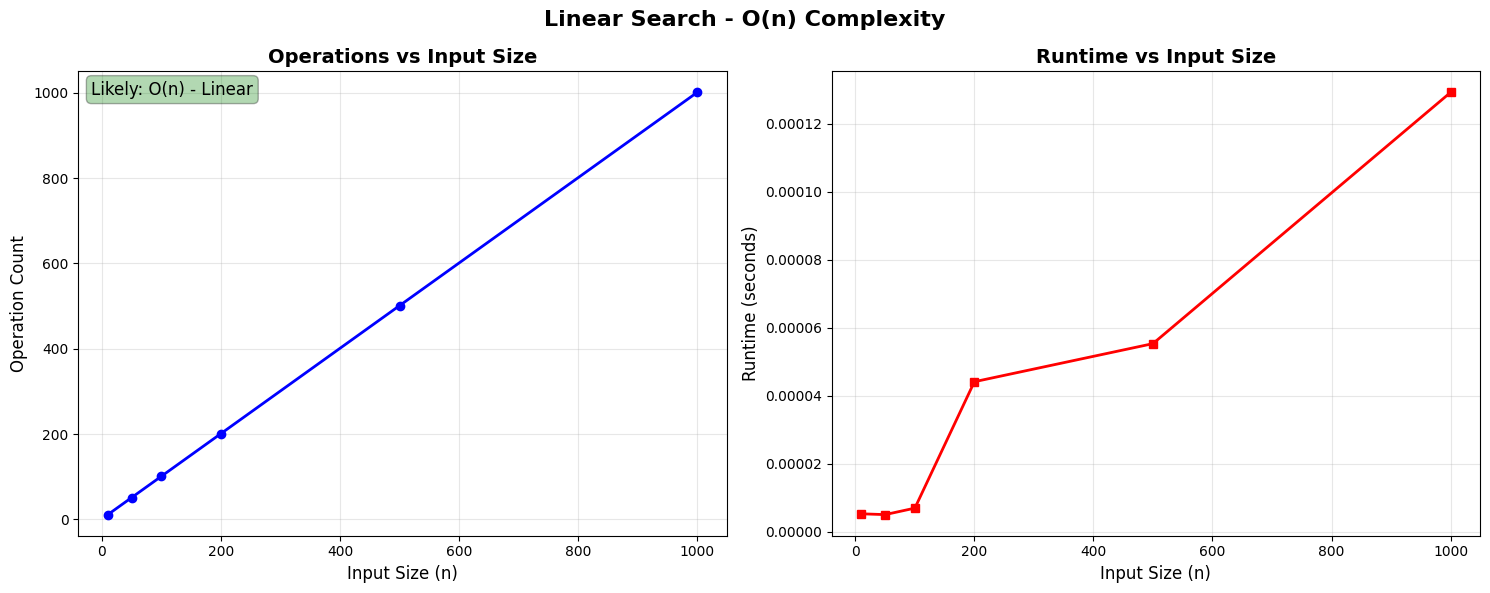


📋 Detailed Results:
Input Size   Operations  Runtime (s)
------------------------------------
        10           11     0.000005
        50           51     0.000005
       100          101     0.000007
       200          201     0.000044
       500          501     0.000055
      1000         1001     0.000129


In [ ]:
# Example 1: Linear Time Complexity O(n)
linear_code = """
def linear_search(n):
    # Simulate searching through n items
    for i in range(n):
        # Simulate some work
        dummy = i * 2
"""

print("🔍 Testing Linear Search Algorithm")
print("Expected: O(n) - operations should grow linearly with input size")
print()

# Test with various input sizes
input_sizes = [10, 50, 100, 200, 500, 1000]
results = run_instrumented_code(linear_code, "linear_search", input_sizes)

# Visualize results
plot_results(results, "Linear Search - O(n) Complexity")

🔄 Testing Bubble Sort Algorithm (FIXED)
Expected: O(n²) - operations should grow quadratically
Real-world: Like comparing every Facebook user with every other user
⚠️  This is why bubble sort is bad for large datasets!

⚠️  Warning: astor module not found. Using simple instrumentation.


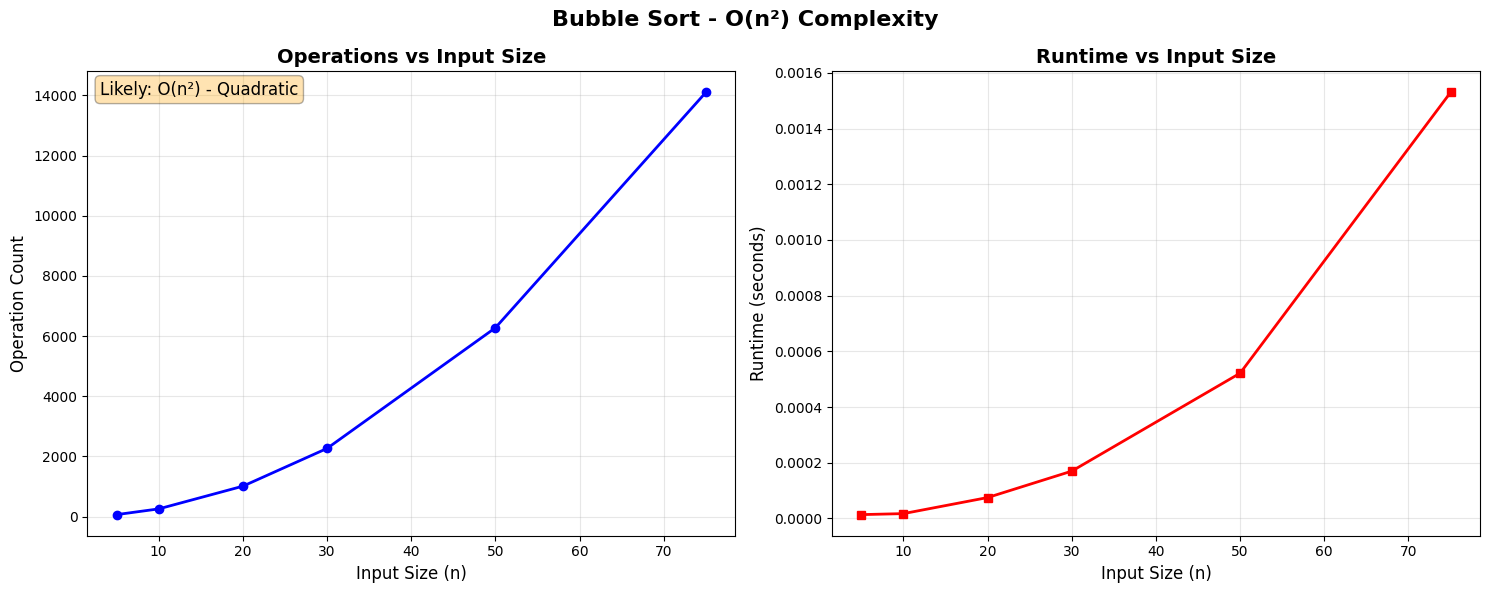


📋 Detailed Results:
Input Size   Operations  Runtime (s)
------------------------------------
         5           66     0.000014
        10          256     0.000017
        20         1011     0.000075
        30         2266     0.000170
        50         6276     0.000522
        75        14101     0.001530


In [ ]:
# Example 2: Quadratic Time Complexity O(n²)
quadratic_code = """
def bubble_sort_steps(n):
    step_counter = 0  # Initialize the counter first!
    # Simulate bubble sort operation counting
    for i in range(n):
        step_counter += 1  # Count outer loop
        for j in range(n - i - 1):
            step_counter += 1  # Count inner loop
            # Simulate comparison operation
            dummy = i + j
            step_counter += 1  # Count the comparison/assignment
    return step_counter
"""

print("🔄 Testing Bubble Sort Algorithm (FIXED)")
print("Expected: O(n²) - operations should grow quadratically")
print("Real-world: Like comparing every Facebook user with every other user")
print("⚠️  This is why bubble sort is bad for large datasets!")
print()

# Test with smaller input sizes (quadratic grows fast!)
input_sizes = [5, 10, 20, 30, 50, 75]
results = run_instrumented_code(quadratic_code, "bubble_sort_steps", input_sizes)

# Visualize results
plot_results(results, "Bubble Sort - O(n²) Complexity")

Testing Constant O(1)...
⚠️  Warning: astor module not found. Using simple instrumentation.
Testing Linear O(n)...
⚠️  Warning: astor module not found. Using simple instrumentation.
Testing Quadratic O(n²)...
⚠️  Warning: astor module not found. Using simple instrumentation.


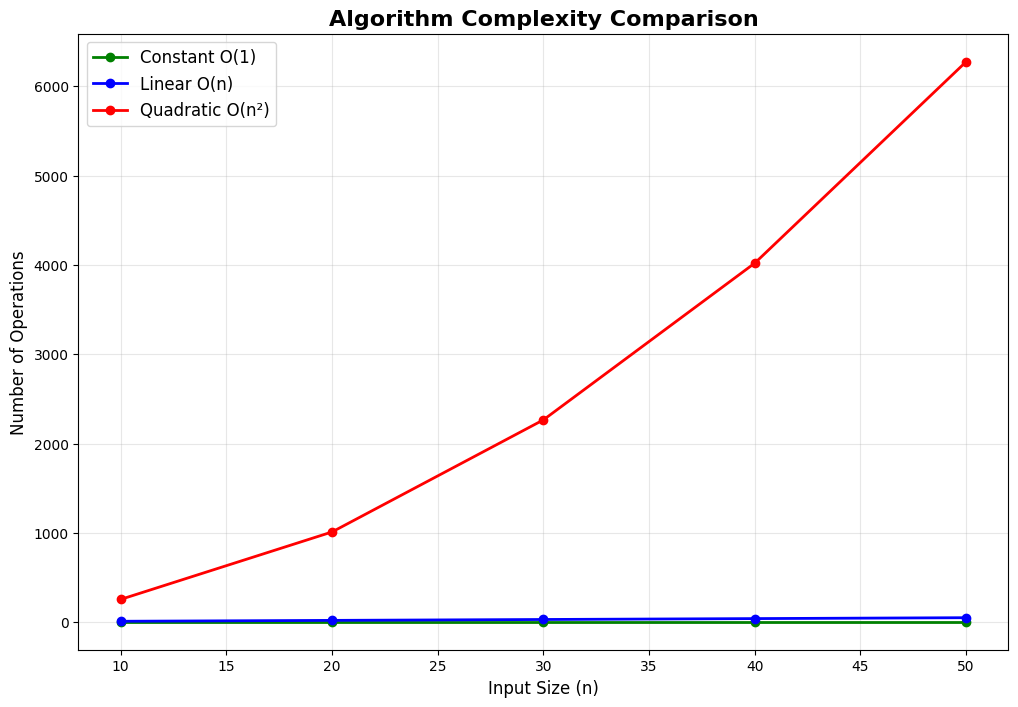


🎯 Key Observations:
• Constant time: Always the same number of operations
• Linear time: Operations increase proportionally with input
• Quadratic time: Operations increase with the square of input


In [ ]:
# Let's compare constant, linear, and quadratic algorithms

constant_code = """
def constant_time(n):
    # This algorithm doesn't depend on n
    for i in range(5):  # Always exactly 5 operations
        dummy = i * 2
"""

# Test all three algorithms
input_sizes = [10, 20, 30, 40, 50]

algorithms = [
    ("Constant O(1)", constant_code, "constant_time"),
    ("Linear O(n)", linear_code, "linear_search"),
    ("Quadratic O(n²)", quadratic_code, "bubble_sort_steps")
]

# Collect results for all algorithms
all_results = {}
for name, code, func_name in algorithms:
    print(f"Testing {name}...")
    results = run_instrumented_code(code, func_name, input_sizes)
    all_results[name] = results

# Create comparison plot
plt.figure(figsize=(12, 8))

colors = ['green', 'blue', 'red']
for i, (name, results) in enumerate(all_results.items()):
    valid_results = [r for r in results if r[1] is not None]
    if valid_results:
        sizes = [r[0] for r in valid_results]
        steps = [r[1] for r in valid_results]
        plt.plot(sizes, steps, marker='o', label=name,
                color=colors[i], linewidth=2, markersize=6)

plt.xlabel('Input Size (n)', fontsize=12)
plt.ylabel('Number of Operations', fontsize=12)
plt.title('Algorithm Complexity Comparison', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print("\n🎯 Key Observations:")
print("• Constant time: Always the same number of operations")
print("• Linear time: Operations increase proportionally with input")
print("• Quadratic time: Operations increase with the square of input")

In [ ]:
# ## 🏆 Step 10: Complete Time Complexity Debugger

def analyze_time_complexity(code_str, func_name, input_sizes=None, title=None):
    """
    Complete Time Complexity Debugger - analyzes any Python function.
    Args:
        code_str: Python code containing the function to analyze
        func_name: Name of the function to test
        input_sizes: List of input sizes to test (optional)
        title: Custom title for the analysis (optional)
    """
    # Default input sizes if not provided
    if input_sizes is None:
        input_sizes = [10, 25, 50, 75, 100, 150, 200]
    # Default title if not provided
    if title is None:
        title = f"Time Complexity Analysis: {func_name}"
    print(f"🔍 Analyzing function: {func_name}")
    print(f"📊 Testing with input sizes: {input_sizes}")
    print("⏳ Running experiments...\n")
    # Run the analysis
    results = run_instrumented_code(code_str, func_name, input_sizes)
    # Create visualization
    plot_results(results, title)
    return results

print("🏆 Complete Time Complexity Debugger ready!")
print("Use analyze_time_complexity(code, function_name) to analyze any algorithm.")

🏆 Complete Time Complexity Debugger ready!
Use analyze_time_complexity(code, function_name) to analyze any algorithm.
